# SQL 데이터베이스와 상호작용하는 에이전트

이 튜토리얼에서는 **SQL 데이터베이스에 대한 질문에 답할 수 있는 에이전트**를 단계별로 구축하는 방법을 소개합니다.  

SQL 쿼리를 실행하는 에이전트의 흐름은 다음과 같습니다.

1. **데이터베이스 스키마 파악**: 사용 가능한 테이블 목록을 가져옵니다.
2. **관련 테이블 선택**: 질문과 연관된 테이블을 선택합니다.
3. **DDL 조회**: 선택된 테이블의 스키마 정의(DDL)를 가져옵니다.
4. **쿼리 생성**: 질문과 DDL 정보에 기반하여 SQL 쿼리를 작성합니다.
5. **쿼리 점검**: LLM을 사용하여 일반적인 오류를 검토하고 쿼리를 개선합니다.
6. **쿼리 실행 및 오류 처리**: 데이터베이스 엔진에 쿼리를 실행하고, 오류 발생 시 수정하여 성공적으로 쿼리를 수행합니다.
7. **응답 생성**: 쿼리 결과를 기반으로 최종 답변을 제공합니다.

![](./assets/langgraph-sql-agent.png)

---

**주요 내용**

- **데이터베이스**: SQLite 데이터베이스 설정 및 `chinook` 샘플 데이터베이스 로드  
- **유틸리티 함수**: 에이전트 구현을 위한 유틸리티 함수 정의  
- **도구 정의**: 데이터베이스와 상호작용하기 위한 도구 정의  
- **워크플로우 정의**: 에이전트의 워크플로우(그래프) 정의  
- **그래프 시각화**: 정의된 그래프 시각화  
- **에이전트 실행**: 에이전트 실행 및 결과 확인  
- **평가**: 에이전트 평가 및 성능 비교  

## 환경 설정

먼저, 필요한 패키지를 설치하고 API 키를 설정합니다.

In [7]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv(override=True)

True

In [2]:
from langfuse.openai import OpenAI  # OpenAI 대신 이걸 사용
import os

client = OpenAI(
    api_key=os.environ["OPENROUTER_API_KEY"],
    base_url=os.environ.get("OPENROUTER_BASE_URL"),  # 사내 프록시 쓰면 여기
)

resp = client.chat.completions.create(
    model="gpt-4.1-mini",
    messages=[{"role": "user", "content": "안녕 Langfuse"}],
)
print(resp.choices[0].message.content)

안녕하세요! Langfuse입니다. 어떻게 도와드릴까요?


In [ ]:
# LangSmith 추적을 설정합니다.
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("LangGraph-Use-Cases")

LangSmith 추적을 시작합니다.
[프로젝트명]
LangGraph-Use-Cases


In [9]:
from langchain_teddynote.models import get_model_name, LLMs

MODEL_NAME = "qwen/qwen3-next-80b-a3b-instruct"
# MODEL_NAME = get_model_name(LLMs.GPT4o)
print(f"사용하는 모델명: {MODEL_NAME}")

사용하는 모델명: qwen/qwen3-next-80b-a3b-instruct


## 데이터베이스 설정

이 튜토리얼에서는 SQLite 데이터베이스를 생성합니다. SQLite는 설정과 사용이 간편한 경량 데이터베이스입니다. 

이번 튜토리얼에서는 샘플 데이터베이스인 `chinook` 데이터베이스를 로드할 예정이며, 이는 디지털 미디어 스토어를 나타내는 샘플 데이터베이스입니다. 

데이터베이스에 대한 자세한 정보는 [여기](https://www.sqlitetutorial.net/sqlite-sample-database/)에서 확인할 수 있습니다.

먼저, 실습에 활용할 `chinook` 데이터베이스를 다운로드 받습니다.

In [10]:
import requests

url = "https://storage.googleapis.com/benchmarks-artifacts/chinook/Chinook.db"

response = requests.get(url)

if response.status_code == 200:
    with open("Chinook.db", "wb") as file:
        file.write(response.content)
    print("File downloaded and saved as Chinook.db")
else:
    print(f"Failed to download the file. Status code: {response.status_code}")

File downloaded and saved as Chinook.db


다음은 다운로드 받은 `chinook` 데이터베이스를 사용하여 `SQLDatabase` 도구를 생성하고 샘플 쿼리인 `"SELECT * FROM Artist LIMIT 5;"`를 실행합니다.

In [ ]:
from langchain_community.utilities import SQLDatabase

# SQLite 데이터베이스 파일에서 SQLDatabase 인스턴스 생성
db = SQLDatabase.from_uri("sqlite:///Chinook.db")

# DB dialect 출력(sqlite)
print(db.dialect)

# 데이터베이스에서 사용 가능한 테이블 이름 목록 출력
print(db.get_usable_table_names())

# SQL 쿼리 실행
db.run("SELECT * FROM Artist LIMIT 5;")

sqlite
['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']


"[(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains')]"

## 유틸리티 함수

에이전트 구현을 돕기 위해 몇 가지 유틸리티 함수를 정의합니다. 

특히, `ToolNode`를 **오류 처리** 와 **에이전트에 오류를 전달하는 기능** 을 포함하여 래핑합니다. 

In [ ]:
from typing import Any

from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda, RunnableWithFallbacks
from langgraph.prebuilt import ToolNode


# 오류 처리 함수
def handle_tool_error(state) -> dict:
    # 오류 정보 조회
    error = state.get("error")
    # 도구 정보 조회
    tool_calls = state["messages"][-1].tool_calls
    # ToolMessage 로 래핑 후 반환
    return {
        "messages": [
            ToolMessage(
                content=f"Here is the error: {repr(error)}\n\nPlease fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }


# 오류를 처리하고 에이전트에 오류를 전달하기 위한 ToolNode 생성
def create_tool_node_with_fallback(tools: list) -> RunnableWithFallbacks[Any, dict]:
    """
    Create a ToolNode with a fallback to handle errors and surface them to the agent.
    """
    # 오류 발생 시 대체 동작을 정의하여 ToolNode에 추가
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )

## SQL 쿼리 실행 도구 

에이전트가 데이터베이스와 상호작용할 수 있도록 몇 가지 도구를 정의합니다.

1. `list_tables_tool`: 데이터베이스에서 사용 가능한 테이블을 가져옵니다.
2. `get_schema_tool`: 테이블의 DDL을 가져옵니다.
3. `db_query_tool`: 쿼리를 실행하고 결과를 가져오거나 쿼리가 실패할 경우 오류 메시지를 반환합니다.

**참고**

- DDL(데이터 정의 언어, **Data Definition Language**)은 데이터베이스의 구조와 스키마를 정의하거나 수정하는 데 사용되는 SQL 명령어들을 지칭합니다. 주로 테이블, 인덱스, 뷰, 스키마 등의 데이터베이스 객체를 생성, 수정, 삭제할 때 사용됩니다.

주요 DDL 명령어

- **`CREATE`**: 데이터베이스 객체를 생성합니다.
  - 예: `CREATE TABLE users (id INT, name VARCHAR(100));`
- **`ALTER`**: 기존 데이터베이스 객체를 수정합니다.
  - 예: `ALTER TABLE users ADD COLUMN email VARCHAR(100);`
- **`DROP`**: 데이터베이스 객체를 삭제합니다.
  - 예: `DROP TABLE users;`

### 데이터베이스 쿼리 관련 도구

다음은 SQL database와 상호작용하기 위한 `SQLDatabaseToolkit` 도구 목록입니다.

**QuerySQLDataBaseTool**

- **기능**: SQL query 실행 및 결과 반환
- **Input**: 정확한 SQL query
- **Output**: Database 결과 또는 error message
- **Error 처리**:
  - Query 오류 발생 시 재작성 및 재시도
  - `Unknown column` 오류 시 `sql_db_schema`로 정확한 table fields 확인

**InfoSQLDatabaseTool**

- **기능**: Table schema 및 sample data 조회
- **Input**: 콤마로 구분된 table 목록
- **사용 예시**: `table1, table2, table3`
- **주의사항**: `sql_db_list_tables`로 table 존재 여부 사전 확인 필요

**ListSQLDatabaseTool**

- **기능**: Database 내 table 목록 조회

**QuerySQLCheckerTool**

- **기능**: Query 실행 전 유효성 검사
- **검사 항목**:
  - NULL 값과 NOT IN 사용
  - UNION vs UNION ALL 적절성
  - BETWEEN 범위 설정
  - Data type 일치 여부
  - Identifier 인용 적절성
  - Function argument 수
  - Data type casting
  - Join column 정확성
- **특징**: GPT-4 model 기반 검증 수행

In [ ]:
import os
llm=ChatOpenAI(model=MODEL_NAME, base_url= os.getenv("OPENROUTER_BASE_URL"),api_key=os.getenv("OPENROUTER_API_KEY"))
llm.invoke("안녕")

AIMessage(content='안녕하세요! 😊  \n어떤 도움이 필요하신가요? 질문이 있으신가요, 아니면 그냥 인사드릴까 하셨나요?  \n언제든지 말해주세요!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 46, 'prompt_tokens': 10, 'total_tokens': 56, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'qwen/qwen3-next-80b-a3b-instruct', 'system_fingerprint': '', 'id': 'gen-1763221434-yV3jUiUSMjzrk1nguMGT', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--d86babcf-2358-4f72-a5a6-3b2c7a4fe4c1-0', usage_metadata={'input_tokens': 10, 'output_tokens': 46, 'total_tokens': 56, 'input_token_details': {}, 'output_token_details': {}})

In [ ]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langchain_openai import ChatOpenAI

# SQLDatabaseToolkit 생성
toolkit = SQLDatabaseToolkit(db=db, llm=ChatOpenAI(model=MODEL_NAME))

# SQLDatabaseToolkit에서 사용 가능한 도구 목록
tools = toolkit.get_tools()
tools

[QuerySQLDatabaseTool(description="Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.", db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x1798e2d50>),
 InfoSQLDatabaseTool(description='Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3', db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x1798e2d50>),
 ListSQLDatabaseTool(db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x1798e2d50>),
 QuerySQLCheckerTool(description='Use this tool to double check if your 

아래는 `list_tables_tool` 과 `get_schema_tool` 에 대한 실행 예시입니다.

In [ ]:
# 데이터베이스에서 사용 가능한 테이블을 나열하는 도구 선택
list_tables_tool = next(tool for tool in tools if tool.name == "sql_db_list_tables")

# 특정 테이블의 DDL을 가져오는 도구 선택
get_schema_tool = next(tool for tool in tools if tool.name == "sql_db_schema")

# 데이터베이스의 모든 테이블 목록 출력
print(list_tables_tool.invoke(""))

# Artist 테이블의 DDL 정보 출력
print(get_schema_tool.invoke("Artist"))

Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track

CREATE TABLE "Artist" (
	"ArtistId" INTEGER NOT NULL, 
	"Name" NVARCHAR(120), 
	PRIMARY KEY ("ArtistId")
)

/*
3 rows from Artist table:
ArtistId	Name
1	AC/DC
2	Accept
3	Aerosmith
*/


다음은 `db_query_tool` 을 정의합니다. 

`db_query_tool`의 경우, 데이터베이스에 대해 쿼리를 실행하고 결과를 반환합니다.

만약, error 가 발생하면 오류 메시지를 반환합니다.

In [ ]:
from langchain_core.tools import tool


# Query 실행 도구
@tool
def db_query_tool(query: str) -> str:
    """
    Run SQL queries against a database and return results
    Returns an error message if the query is incorrect
    If an error is returned, rewrite the query, check, and retry
    """
    # 쿼리 실행
    result = db.run_no_throw(query)

    # 오류: 결과가 없으면 오류 메시지 반환
    if not result:
        return "Error: Query failed. Please rewrite your query and try again."
    # 정상: 쿼리 실행 결과 반환
    return result

정상 실행된 경우

In [ ]:
# Artist 테이블에서 상위 10개 행 선택 및 실행 결과 출력
print(db_query_tool.invoke("SELECT * FROM Artist LIMIT 10;"))

[(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains'), (6, 'Antônio Carlos Jobim'), (7, 'Apocalyptica'), (8, 'Audioslave'), (9, 'BackBeat'), (10, 'Billy Cobham')]


오류가 발생한 경우 예시

In [ ]:
# Artist 테이블에서 상위 10개 행 선택 및 실행 결과 출력
print(db_query_tool.invoke("SELECT * FROM Artist LIMITS 10;"))

Error: (sqlite3.OperationalError) near "10": syntax error
[SQL: SELECT * FROM Artist LIMITS 10;]
(Background on this error at: https://sqlalche.me/e/20/e3q8)


### SQL 쿼리 점검(SQL Query Checker)

다음은, SQL 쿼리에서 일반적인 실수를 점검하기 위해 LLM을 활용할 예정입니다. 

이는 엄밀히 말하면 도구는 아니지만, 이후 워크플로우에 노드로 추가될 것입니다.

In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

# SQL 쿼리의 일반적인 실수를 점검하기 위한 시스템 메시지 정의
query_check_system = """You are a SQL expert with a strong attention to detail.
Double check the SQLite query for common mistakes, including:
- Using NOT IN with NULL values
- Using UNION when UNION ALL should have been used
- Using BETWEEN for exclusive ranges
- Data type mismatch in predicates
- Properly quoting identifiers
- Using the correct number of arguments for functions
- Casting to the correct data type
- Using the proper columns for joins

If there are any of the above mistakes, rewrite the query. If there are no mistakes, just reproduce the original query.

You will call the appropriate tool to execute the query after running this check."""

# 프롬프트 생성
query_check_prompt = ChatPromptTemplate.from_messages(
    [("system", query_check_system), ("placeholder", "{messages}")]
)

# Query Checker 체인 생성
query_check = query_check_prompt | ChatOpenAI(
    model=MODEL_NAME, temperature=0, base_url= os.getenv("OPENROUTER_BASE_URL"),api_key=os.getenv("OPENROUTER_API_KEY")
# ).bind_tools([db_query_tool])
).bind_tools([db_query_tool], tool_choice="db_query_tool")

잘못된 쿼리를 날려 호출하여 결과가 잘 수정되었는지 확인합니다.

**참고**

- `LIMIT` 대신 `LIMITS` 을 사용하여 쿼리를 날렸습니다.

In [ ]:
# 사용자 메시지를 사용하여 쿼리 점검 노드 실행
response = query_check.invoke(
    {"messages": [("user", "SELECT * FROM Artist LIMITS 10;")]}
)
# print(response.tool_calls)
print(response.tool_calls[0])

NameError: name 'query_check' is not defined

결과는 잘 수정되었습니다.

## 그래프 정의

에이전트의 워크플로우를 정의합니다. 

에이전트는 먼저 `list_tables_tool`을 강제로 호출하여 데이터베이스에서 사용 가능한 테이블을 가져온 후, 튜토리얼 초반에 언급된 단계를 따릅니다.

In [ ]:
from typing import Annotated, Literal

from langchain_core.messages import AIMessage
from langchain_openai import ChatOpenAI

from pydantic import BaseModel, Field
from typing_extensions import TypedDict

from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import AnyMessage, add_messages
from langgraph.checkpoint.memory import MemorySaver


# 에이전트의 상태 정의
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]


# 새로운 그래프 정의
workflow = StateGraph(State)


# 첫 번째 도구 호출을 위한 노드 추가
def first_tool_call(state: State) -> dict[str, list[AIMessage]]:
    return {
        "messages": [
            AIMessage(
                content="",
                tool_calls=[
                    {
                        "name": "sql_db_list_tables",
                        "args": {},
                        "id": "initial_tool_call_abc123",
                    }
                ],
            )
        ]
    }


# 쿼리의 정확성을 모델로 점검하기 위한 함수 정의
def model_check_query(state: State) -> dict[str, list[AIMessage]]:
    """
    Use this tool to check that your query is correct before you run it
    """
    return {"messages": [query_check.invoke({"messages": [state["messages"][-1]]})]}


# 첫 번째 도구 호출 노드 추가
workflow.add_node("first_tool_call", first_tool_call)

# 첫 번째 두 도구를 위한 노드 추가
workflow.add_node(
    "list_tables_tool", create_tool_node_with_fallback([list_tables_tool])
)
workflow.add_node("get_schema_tool", create_tool_node_with_fallback([get_schema_tool]))

# 질문과 사용 가능한 테이블을 기반으로 관련 테이블을 선택하는 모델 노드 추가
model_get_schema = ChatOpenAI(model=MODEL_NAME, temperature=0,base_url= os.getenv("OPENROUTER_BASE_URL"),api_key=os.getenv("OPENROUTER_API_KEY")).bind_tools(
    [get_schema_tool]
)
workflow.add_node(
    "model_get_schema",
    lambda state: {
        "messages": [model_get_schema.invoke(state["messages"])],
    },
)


# 최종 상태를 나타내는 도구 설명
class SubmitFinalAnswer(BaseModel):
    """쿼리 결과를 기반으로 사용자에게 최종 답변 제출"""

    final_answer: str = Field(..., description="The final answer to the user")


# 질문과 스키마를 기반으로 쿼리를 생성하기 위한 모델 노드 추가
QUERY_GEN_INSTRUCTION = """You are a SQL expert with a strong attention to detail.

You can define SQL queries, analyze queries results and interpretate query results to response an answer.

Read the messages bellow and identify the user question, table schemas, query statement and query result, or error if they exist.

1. If there's not any query result that make sense to answer the question, create a syntactically correct SQLite query to answer the user question. DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.

2. If you create a query, response ONLY the query statement. For example, "SELECT id, name FROM pets;"

3. If a query was already executed, but there was an error. Response with the same error message you found. For example: "Error: Pets table doesn't exist"

4. If a query was already executed successfully interpretate the response and answer the question following this pattern: Answer: <<question answer>>. For example: "Answer: There three cats registered as adopted"
"""

query_gen_prompt = ChatPromptTemplate.from_messages(
    [("system", QUERY_GEN_INSTRUCTION), ("placeholder", "{messages}")]
)
query_gen = query_gen_prompt | ChatOpenAI(model=MODEL_NAME, temperature=0,base_url= os.getenv("OPENROUTER_BASE_URL"),api_key=os.getenv("OPENROUTER_API_KEY")).bind_tools(
    [SubmitFinalAnswer, model_check_query]
)


# 조건부 에지 정의
def should_continue(state: State) -> Literal[END, "correct_query", "query_gen"]:
    messages = state["messages"]

    last_message = messages[-1]
    if last_message.content.startswith("Answer:"):
        return END
    if last_message.content.startswith("Error:"):
        return "query_gen"
    else:
        return "correct_query"


# 쿼리 생성 노드 정의
def query_gen_node(state: State):
    message = query_gen.invoke(state)

    # LLM이 잘못된 도구를 호출할 경우 오류 메시지를 반환
    tool_messages = []
    message.pretty_print()
    if message.tool_calls:
        for tc in message.tool_calls:
            if tc["name"] != "SubmitFinalAnswer":
                tool_messages.append(
                    ToolMessage(
                        content=f"Error: The wrong tool was called: {tc['name']}. Please fix your mistakes. Remember to only call SubmitFinalAnswer to submit the final answer. Generated queries should be outputted WITHOUT a tool call.",
                        tool_call_id=tc["id"],
                    )
                )
    else:
        tool_messages = []
    return {"messages": [message] + tool_messages}


# 쿼리 생성 노드 추가
workflow.add_node("query_gen", query_gen_node)

# 쿼리를 실행하기 전에 모델로 점검하는 노드 추가
workflow.add_node("correct_query", model_check_query)

# 쿼리를 실행하기 위한 노드 추가
workflow.add_node("execute_query", create_tool_node_with_fallback([db_query_tool]))

# 노드 간의 엣지 지정
workflow.add_edge(START, "first_tool_call")
workflow.add_edge("first_tool_call", "list_tables_tool")
workflow.add_edge("list_tables_tool", "model_get_schema")
workflow.add_edge("model_get_schema", "get_schema_tool")
workflow.add_edge("get_schema_tool", "query_gen")
workflow.add_conditional_edges(
    "query_gen",
    should_continue,
)
workflow.add_edge("correct_query", "execute_query")
workflow.add_edge("execute_query", "query_gen")

# 실행 가능한 워크플로우로 컴파일
app = workflow.compile(checkpointer=MemorySaver())

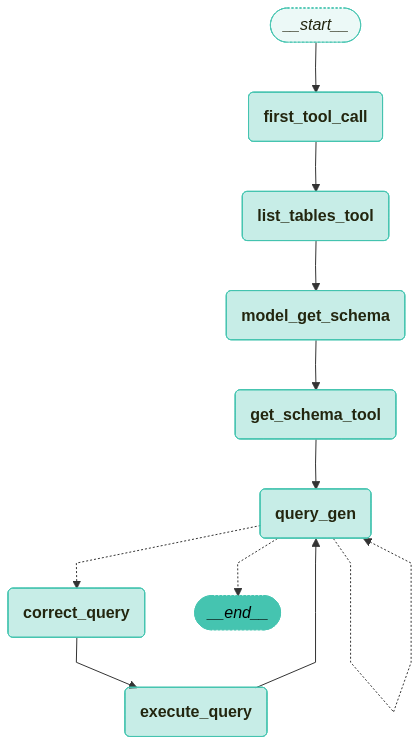

In [ ]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(app, xray=True)

## 그래프 실행

에이전트를 실행하여 SQL 데이터베이스와 상호작용하는 전체 프로세스를 진행합니다.

에이전트는 사용자의 질문에 따라 데이터베이스에서 정보를 검색하고, 쿼리를 생성 및 실행하여 결과를 반환합니다. 

In [ ]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import random_uuid, invoke_graph, stream_graph
from langchain_core.messages import HumanMessage
from langgraph.errors import GraphRecursionError


def run_graph(
    message: str, recursive_limit: int = 30, node_names=[], stream: bool = False
):
    # config 설정(재귀 최대 횟수, thread_id)
    config = RunnableConfig(
        recursion_limit=recursive_limit, configurable={"thread_id": random_uuid()}
    )

    # 질문 입력
    inputs = {
        "messages": [HumanMessage(content=message)],
    }

    try:
        if stream:
            # 그래프 실행
            stream_graph(app, inputs, config, node_names=node_names)
        else:
            invoke_graph(app, inputs, config, node_names=node_names)
        output = app.get_state(config).values
        return output
    except GraphRecursionError as recursion_error:
        print(f"GraphRecursionError: {recursion_error}")
        output = app.get_state(config).values
        return output

In [ ]:
output = run_graph(
    # "Customer 컬럼 알려줘",
    # "Andrew Adam 직원의 인적정보를 모두 조회해줘",
    "넌누구야?",
    stream=False,
)


🔄 Node: first_tool_call 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (initial_tool_call_abc123)
 Call ID: initial_tool_call_abc123
  Args:

🔄 Node: list_tables_tool 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================= Tool Message =================================
Name: sql_db_list_tables

Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track

🔄 Node: model_get_schema 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================

저는 데이터베이스를 탐색하고 쿼리할 수 있는 AI 어시스턴트입니다. 사용 가능한 테이블은 다음과 같습니다: Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track. 어떤 정보를 찾고 계신가요?

🔄 Node: get_schema_tool 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
========================

In [ ]:
output = run_graph(
    "2009년도에 어느 국가의 고객이 가장 많이 지출했을까요? 그리고 얼마를 지출했을까요? 해당 고객으로 연도별 지출금액을 barchart로 그려줘",
    # "2009년도에 어느 국가의 고객이 가장 많이 지출했을까요? 그리고 얼마를 지출했을까요? 한글로 답변하세요. ",
    stream=False,
)


🔄 Node: first_tool_call 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (initial_tool_call_abc123)
 Call ID: initial_tool_call_abc123
  Args:

🔄 Node: list_tables_tool 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================= Tool Message =================================
Name: sql_db_list_tables

Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track

🔄 Node: model_get_schema 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (call_62a2f8d7f8f24ee7ba9a2f67)
 Call ID: call_62a2f8d7f8f24ee7ba9a2f67
  Args:
    table_names: Customer, Invoice

🔄 Node: get_schema_tool 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================= Tool Message ==================

## LangSmith Evaluator 를 활용한 SQL Agent 평가

이제 생성한 Agent 의 SQL 쿼리 응답을 평가합니다. 쿼리 응답을 평가하기 위한 평가용 데이터셋을 생성합니다.

다음으로는 평가자를 정의하고 평가를 진행합니다.

이때 활용하는 평가자는 LLM-as-judge 이며, 사용하는 프롬프트는 기본 hub 에서 제공하는 프롬프트를 활용합니다.

다만, 보다 정확한 평가를 위해서 각자 프롬프트를 튜닝하여 사용하는 것을 권장합니다.

In [ ]:
from langsmith import Client

# 클라이언트 초기화
client = Client()

# 데이터셋 생성 및 업로드
examples = [
    (
        "Which country's customers spent the most? And how much did they spend?",
        "The country whose customers spent the most is the USA, with a total spending of 523.06.",
    ),
    (
        "What was the most purchased track of 2013?",
        "The most purchased track of 2013 was Hot Girl.",
    ),
    (
        "How many albums does the artist Led Zeppelin have?",
        "Led Zeppelin has 14 albums",
    ),
    (
        "What is the total price for the album “Big Ones”?",
        "The total price for the album 'Big Ones' is 14.85",
    ),
    (
        "Which sales agent made the most in sales in 2009?",
        "Steve Johnson made the most sales in 2009",
    ),
]

dataset_name = "SQL Agent Response"

if not client.has_dataset(dataset_name=dataset_name):
    dataset = client.create_dataset(dataset_name=dataset_name)
    inputs, outputs = zip(
        *[({"input": text}, {"output": label}) for text, label in examples]
    )
    client.create_examples(inputs=inputs, outputs=outputs, dataset_id=dataset.id)

다음으로는 우리가 만든 에이전트의 SQL 쿼리 응답을 예측하기 위한 함수를 정의합니다.

In [ ]:
# 에이전트의 SQL 쿼리 응답을 예측하기 위한 함수 정의
def predict_sql_agent_answer(example: dict):
    """Use this for answer evaluation"""
    config = RunnableConfig(configurable={"thread_id": random_uuid()})

    inputs = {
        "messages": [HumanMessage(content=example["input"])],
    }
    # 그래프를 실행하여 메시지 결과 조회
    messages = app.invoke(inputs, config)
    answer = messages["messages"][-1].content
    # 결과 반환
    return {"response": answer}

SQL 쿼리 응답을 평가하기 위한 프롬프트와 평가자(LLM-as-judge) 를 정의합니다.

In [ ]:
from langchain import hub
from langchain_openai import ChatOpenAI

# Grade prompt
grade_prompt_answer_accuracy = hub.pull("langchain-ai/rag-answer-vs-reference")


# 답변 평가자 LLM-as-judge 정의
def answer_evaluator(run, example) -> dict:
    # input: 질문
    input_question = example.inputs["input"]
    # output: 참조 답변
    reference = example.outputs["output"]
    # 예측 답변
    prediction = run.outputs["response"]

    # LLM 평가자 초기화
    llm = ChatOpenAI(model=MODEL_NAME, temperature=0)
    answer_grader = grade_prompt_answer_accuracy | llm

    # 평가자 실행
    score = answer_grader.invoke(
        {
            "question": input_question,
            "correct_answer": reference,
            "student_answer": prediction,
        }
    )
    score = score["Score"]

    # 점수 반환
    return {"key": "answer_v_reference_score", "score": score}

이제, 평가를 수행하고 결과를 확인합니다.

In [ ]:
from langsmith.evaluation import evaluate

# 평가용 데이터셋 이름
dataset_name = "SQL Agent Response"

try:
    # 평가 진행
    experiment_results = evaluate(
        predict_sql_agent_answer,  # 평가시 활용할 예측 함수
        data=dataset_name,  # 평가용 데이터셋 이름
        evaluators=[answer_evaluator],  # 평가자 목록
        num_repetitions=3,  # 실험 반복 횟수 설정
        experiment_prefix="sql-agent-eval",
        metadata={
            "version": "chinook db, sql-agent-eval: gpt-4.1-mini"
        },  # 실험 메타데이터
    )
except Exception as e:
    print(e)

View the evaluation results for experiment: 'sql-agent-eval-3766971d' at:
https://smith.langchain.com/o/74a885b2-b5ec-4752-ae95-0c0894e0a2fd/datasets/8495175e-53f3-43bb-a289-b3c34f516517/compare?selectedSessions=5628e334-7081-466e-8b6e-d32a571df3e8




0it [00:00, ?it/s]

================================== Ai Message ==================================
Tool Calls:
  model_check_query (call_kFi71rHWuNLfjzJLWI3BpFTX)
 Call ID: call_kFi71rHWuNLfjzJLWI3BpFTX
  Args:
    state: {'messages': [{'content': 'How many albums does the artist Led Zeppelin have?', 'type': 'human'}, {'content': 'CREATE TABLE "Album" (\n\t"AlbumId" INTEGER NOT NULL, \n\t"Title" NVARCHAR(160) NOT NULL, \n\t"ArtistId" INTEGER NOT NULL, \n\tPRIMARY KEY ("AlbumId"), \n\tFOREIGN KEY("ArtistId") REFERENCES "Artist" ("ArtistId")\n)\n\n/*\n3 rows from Album table:\nAlbumId\tTitle\tArtistId\n1\tFor Those About To Rock We Salute You\t1\n2\tBalls to the Wall\t2\n3\tRestless and Wild\t2\n*/\n\n\nCREATE TABLE "Artist" (\n\t"ArtistId" INTEGER NOT NULL, \n\t"Name" NVARCHAR(120), \n\tPRIMARY KEY ("ArtistId")\n)\n\n/*\n3 rows from Artist table:\nArtistId\tName\n1\tAC/DC\n2\tAccept\n3\tAerosmith\n*/', 'type': 'function', 'name': 'sql_db_schema'}]}
================================== Ai Message ==========

Error running target function: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-suC36uLpYlp38Dn0ySfZsGJE on tokens per min (TPM): Limit 30000, Used 29248, Requested 769. Please try again in 34ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}}
Traceback (most recent call last):
  File "/Users/daehwankim/Documents/langgraph-tutorial-main/.venv/lib/python3.13/site-packages/langsmith/evaluation/_runner.py", line 1923, in _forward
    fn(*args, langsmith_extra=langsmith_extra)
    ~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/hc/ll05l0gj6cl27x40w2r115kh0000gn/T/ipykernel_96710/1850029511.py", line 10, in predict_sql_agent_answer
    messages = app.invoke(inputs, config)
  File "/Users/daehwankim/Documents/langgraph-tutorial-main/.venv/lib/python3.13/site-packages/langgraph/pregel/main.py", line 3085, in invoke
    for chunk in self.stream(
    

================================== Ai Message ==================================
Tool Calls:
  model_check_query (call_zQuFyATV6PWqrWfvKCJdtYOd)
 Call ID: call_zQuFyATV6PWqrWfvKCJdtYOd
  Args:
    state: {'messages': [{'content': 'What is the total price for the album “Big Ones”?', 'type': 'human'}, {'content': 'Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track', 'type': 'function', 'name': 'sql_db_list_tables'}, {'content': 'CREATE TABLE "Album" (\n\t"AlbumId" INTEGER NOT NULL, \n\t"Title" NVARCHAR(160) NOT NULL, \n\t"ArtistId" INTEGER NOT NULL, \n\tPRIMARY KEY ("AlbumId"), \n\tFOREIGN KEY("ArtistId") REFERENCES "Artist" ("ArtistId")\n)\n\n/*\n3 rows from Album table:\nAlbumId\tTitle\tArtistId\n1\tFor Those About To Rock We Salute You\t1\n2\tBalls to the Wall\t2\n3\tRestless and Wild\t2\n*/\n\n\nCREATE TABLE "Invoice" (\n\t"InvoiceId" INTEGER NOT NULL, \n\t"CustomerId" INTEGER NOT NULL, \n\t"InvoiceDate" DATETIME NOT NULL, \n\t"B

Error running target function: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-suC36uLpYlp38Dn0ySfZsGJE on tokens per min (TPM): Limit 30000, Used 30000, Requested 816. Please try again in 1.632s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}}
Traceback (most recent call last):
  File "/Users/daehwankim/Documents/langgraph-tutorial-main/.venv/lib/python3.13/site-packages/langsmith/evaluation/_runner.py", line 1923, in _forward
    fn(*args, langsmith_extra=langsmith_extra)
    ~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/hc/ll05l0gj6cl27x40w2r115kh0000gn/T/ipykernel_96710/1850029511.py", line 10, in predict_sql_agent_answer
    messages = app.invoke(inputs, config)
  File "/Users/daehwankim/Documents/langgraph-tutorial-main/.venv/lib/python3.13/site-packages/langgraph/pregel/main.py", line 3085, in invoke
    for chunk in self.stream(
  

================================== Ai Message ==================================
Tool Calls:
  model_check_query (call_B34aZ7xNaDyfkqAv6JhBKlT6)
 Call ID: call_B34aZ7xNaDyfkqAv6JhBKlT6
  Args:
    state: {'messages': [{'content': 'What is the total price for the album “Big Ones”?', 'type': 'human'}, {'content': 'Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track', 'type': 'function', 'name': 'sql_db_list_tables'}, {'content': 'CREATE TABLE "Album" (\n\t"AlbumId" INTEGER NOT NULL, \n\t"Title" NVARCHAR(160) NOT NULL, \n\t"ArtistId" INTEGER NOT NULL, \n\tPRIMARY KEY ("AlbumId"), \n\tFOREIGN KEY("ArtistId") REFERENCES "Artist" ("ArtistId")\n)\n\n/*\n3 rows from Album table:\nAlbumId\tTitle\tArtistId\n1\tFor Those About To Rock We Salute You\t1\n2\tBalls to the Wall\t2\n3\tRestless and Wild\t2\n*/\n\n\nCREATE TABLE "Invoice" (\n\t"InvoiceId" INTEGER NOT NULL, \n\t"CustomerId" INTEGER NOT NULL, \n\t"InvoiceDate" DATETIME NOT NULL, \n\t"B

Error running target function: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-suC36uLpYlp38Dn0ySfZsGJE on tokens per min (TPM): Limit 30000, Used 30000, Requested 218. Please try again in 436ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}}
Traceback (most recent call last):
  File "/Users/daehwankim/Documents/langgraph-tutorial-main/.venv/lib/python3.13/site-packages/langsmith/evaluation/_runner.py", line 1923, in _forward
    fn(*args, langsmith_extra=langsmith_extra)
    ~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/hc/ll05l0gj6cl27x40w2r115kh0000gn/T/ipykernel_96710/1850029511.py", line 10, in predict_sql_agent_answer
    messages = app.invoke(inputs, config)
  File "/Users/daehwankim/Documents/langgraph-tutorial-main/.venv/lib/python3.13/site-packages/langgraph/pregel/main.py", line 3085, in invoke
    for chunk in self.stream(
   

평가 결과는 생성된 URL 에서 각자 확인할 수 있습니다.

![](./assets/langgraph-sql-agent-evaluation.png)